### This purpose of this code is to read raw altimetry data from a server in Alaska and then ingest it into the postgres database

#### we'll use the Python library http://pysftp.readthedocs.org/en/release_0.2.8/

#### A. Arendt, S. Nimmagadda, C. Larsen

##### rev. 2015 11 17: initial creation
##### 2015 11 29: stepping through ReadLambFile from Evan's UpdateDb.py; removing str/dict distinction; trying in Pandas instead

establish the secure FTP connection:

In [16]:
# so we can display plots in the notebook

%matplotlib inline 
import pandas as pd
import pysftp
import UpdateDb as udb
import Altimetry as alt

# I've set up some sample data here. We'll replace this connection with the real one after developing the code
sftp = pysftp.Connection('40.118.160.139', username='sai', password='altimetry')

In [3]:
glacierList = sftp.listdir('altimetry')
glacierList

['Kahiltna', 'Taku']

In [ ]:
with sftp.cd('altimetry'):
     for glacierName in glacierList:
        with (sftp.cd(glacierName)):
            for fileName in sftp.listdir():
                #verify on interpreter the file about to be downloaded
                if(fileName.endswith(".output.txt")):
                    print(fileName)
                    sftp.get(fileName)

In [8]:
# for now: hard code the name of the test input file

lambfile = 'Taku.2012.2014.output.txt'

glacierInfo = pd.read_csv(lambfile,sep='\t', header=None, names = ['Year1','JDay1','Year2','JDay2',
                                                          'VolModel','Vol25Diff','Vol75Diff',
                                                          'BalModel', 'Bal25Diff', 'Bal75Diff'], skiprows=1, nrows=1)

glacierData = pd.read_csv(lambfile,sep='\t', header=None, names = ['E','DZ','DZ25','DZ75',
                                                          'AAD','MassChange','MassBal','NumData'], skiprows=3)

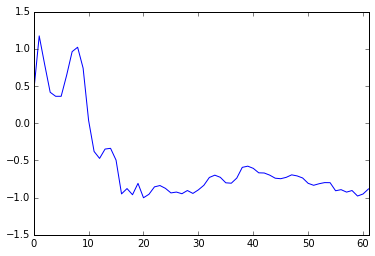

In [9]:
# now we can take advantage of the simple plotting functions in Pandas
glacierData['MassBal'].plot()

In [11]:
glacierData['E'].as_matrix()

array([   0,   30,   60,   90,  120,  150,  180,  210,  240,  270,  300,
        330,  360,  390,  420,  450,  480,  510,  540,  570,  600,  630,
        660,  690,  720,  750,  780,  810,  840,  870,  900,  930,  960,
        990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290,
       1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620,
       1650, 1680, 1710, 1740, 1770, 1800, 1830], dtype=int64)

In [ ]:
#loop over each column in the dataframe and print the contents
for columnName in glacierData:
    print(columnName)
    print(glacierData[columnName].as_matrix())

In [ ]:
from sqlalchemy import create_engine
from base64 import b64decode as readpassword

user = r'sai'
word = r'test'

engine = create_engine('postgresql://' + user + ':' + word + '@localhost:5432/sandbox')
print(engine)

# to send a Pandas dataframe directly to postgreSQL:
# df.to_sql("tableName", engine)

# to issue a standard SQL command:
# engine.execute("ALTER TABLE gulkpoints ADD COLUMN gid SERIAL;")




In [1]:
import Altimetry as alt
connection,cursor = alt.ConnectDb()
print "Host is %s " % alt.ConnectDb(get_host=True)
print "User is %s " % alt.ConnectDb(get_user=True)
print "DBname is %s \n" % alt.ConnectDb(get_dbname=True)

Host is localhost 
User is arendta 
DBname is sandbox 



In [3]:
taku = alt.GetLambData(removerepeats=True,by_column=False,as_object=False, verbose=True,userwhere="ergi_mat_view.name='Taku Glacier'") 

SELECT  lamb.lambid,lamb.ergiid,lamb.date1,lamb.date2,lamb.interval,lamb.volmodel,lamb.vol25diff,lamb.vol75diff,lamb.balmodel,lamb.bal25diff,lamb.bal75diff,ergi_mat_view.surge,ergi_mat_view.gltype,ergi_mat_view.name,ergi_mat_view.region,lamb.e,lamb.dz,lamb.dz25,lamb.dz75,lamb.aad,lamb.masschange,lamb.massbal,lamb.numdata,ergi_mat_view.max::real,ergi_mat_view.min::real,ergi_mat_view.continentality,ergi_mat_view.area::double precision FROM lamb LEFT JOIN ergi_mat_view ON lamb.ergiid=ergi_mat_view.ergiid WHERE ((interval % 365) > 335 OR (interval % 365) < 30) AND ROUND(interval/365.) >= 0 AND ergi_mat_view.name='Taku Glacier' ORDER BY ergi_mat_view.name,lamb.date1,lamb.interval;


UnboundLocalError: local variable 's' referenced before assignment